# House Prices: Advanced Regression Techniques

This goal of this project was to predict sales prices and practice feature engineering, RFs, and gradient boosting. The dataset was part of the [House Prices Kaggle Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). 

<br>

### Table of Contents
* [1 Summary](#1-Summary)

* [2 Introduction](#2-Introduction) 
* [3 Loading & Exploring the Data](#3-Loading-&-Exploring-the-Data-Structure)
    * [3.1 Loading Required Libraries and Reading the Data into Python](#3.1-Loading-Required-Libraries-and-Reading-the-Data-into-Python)
    * [3.2 Data Structure](#3.2-Data-Structure)
 

* [4 Exploring the Variables](#4-Exploring-the-Variables)
    * [4.1 Exploring the Response Variable: SalePrice](#4.1-Exploring-the-Response-Variable:-SalePrice)
    * [4.2 Log-Transformation of the Response Variable](#4.2-Log-Transformation-of-the-Response-Variable)
 

* [5 Data Imputation](#5-Data-Imputation)
    * [5.1 Completeness of the Data](#5.1-Completeness-of-the-Data)
    * [5.2 Impute the Missing Data](#5.2-Impute-the-Missing-Data)
        * [5.2.1 Missing Values Corresponding to Lack of Specific Feature](#5.2.1-Missing-Values-Corresponding-to-Lack-of-Specific-Feature)
        * [5.2.2 Mode Imputation: Replacing Missing Values with Most Frequent Value](#5.2.2-Mode-Imputation:-Replacing-Missing-Values-with-Most-Frequent-Value)

 
* [6 Feature Engineering](#6-Feature-Engineering)
    * [6.1 Mixed Conditions](#6.1-Mixed-Conditions)
    * [6.2 Mixed Exterior](#6.2-Mixed-Exterior)
    * [6.3 Total Square Feet](#6.3-Total-Square-Feet)
    * [6.4 Total Number of Bathrooms](#6.4-Total-Number-of-Bathrooms)
    * [6.5 Binning the Neighbourhoods](#6.5-Binning-the-Neighbourhoods)

 
* [7 LotFrontage Imputation](#7-LotFrontage-Imputation)
    * [7.1 LotFrontage Data Structure](#7.1-LotFrontage-Data-Structure)
    * [7.2 Outlier Detection & Removal](#7.2-Outlier-Detection-&-Removal)
    * [7.3 Determining Relevant Variables of LotFrontage](#7.3-Determining-Relevant-Variables-of-LotFrontage)
    * [7.4 LotFrontage Model Building and Evaluation](#7.4-LotFrontage-Model-Building-and-Evaluation)

 
* [8 Preparing the Data for Modelling](#8-Preparing-the-Data-for-Modelling)
    * [8.1 Removing Outliers](#8.1-Removing-Outliers)
    * [8.2 Correlation Between Numeric Predictors](#8.2-Correlation-Between-Numeric-Predictors)
    * [8.3 Label Encoding](#8.3-Label-Encoding)
    * [8.4 Skewness & Normalization of Numeric Variables](#8.4-Skewness-&-Normalization-of-Numeric-Variables)
    * [8.5 One Hot Encoding the Categorical Variables](#8.5-One-Hot-Encoding-the-Categorical-Variables)

 
* [9 SalePrice Modelling](#9-SalePrice-Modelling)
    * [9.1 Obtaining Final Train and Test Sets](#9.1-Obtaining-Final-Train-and-Test-Sets)
    * [9.2 Defining a Cross Validation Strategy](#9.2-Defining-a-Cross-Validation-Strategy)
    * [9.3 Lasso Regression Model](#9.3-Lasso-Regression-Model)
    * [9.4 Ridge Regression Model](#9.4-Ridge-Regression-Model)
    * [9.5 XGBoost Model](#9.5-XGBoost-Model)
    * [9.6 Ensemble Model](#9.6-Ensemble-Model)


<br>



### Competition Description
> Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

>With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

### Competition Evaluation
As part of a Kaggle competition dataset, the accuracy of the sales prices was evaluated on [Root-Mean-Squared-Error (RMSE)](https://en.wikipedia.org/wiki/Root-mean-square_deviation) between the logarithm of the predicted value and the logarithm of the observed sales price.

____

# 3 Loading & Exploring the Data Structure

## 3.1 Loading Required Libraries and Reading the Data into Python

Loading Python packages used in the project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from time import time

from math import sqrt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as st
from scipy.special import boxcox1p

from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import make_pipeline
from xgboost.sklearn import XGBRegressor

%matplotlib inline

Now, we read in the csv's as datarames into Python.

In [2]:
train = pd.read_csv('train1.csv')
test = pd.read_csv('test.csv')

## 3.2 Data Structure

In total, there are 81 columns/variables in the train dataset, including the response variable (SalePrice). I am only displaying a subset of the variables, as all of them will be discussed in more detail throughout the notebook.

The train dataset consists of character and integer variables. Many of these variables are ordinal factors, despite being represented as character or integer variables. These will require cleaning and/or feature engineering later.

In [3]:
print("Dimensions of Train Dataset:" + str(train.shape))
print("Dimensions of Test Dataset:" + str(test.shape))

Dimensions of Train Dataset:(1460, 81)
Dimensions of Test Dataset:(1459, 80)


In [4]:
train.iloc[:,0:10].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 10 columns):
Id             1460 non-null int64
MSSubClass     1460 non-null int64
MSZoning       1460 non-null object
LotFrontage    1201 non-null float64
LotArea        1460 non-null int64
Street         1460 non-null object
Alley          91 non-null object
LotShape       1460 non-null object
LandContour    1460 non-null object
Utilities      1460 non-null object
dtypes: float64(1), int64(3), object(6)
memory usage: 114.2+ KB


Next, we are going to define a few variables that will be used in later analyses as well as being required for the submission file.

In [5]:
y_train = train['SalePrice']
test_id = test['Id']

ntrain = train.shape[0]
ntest = test.shape[0]

Lastly, we are going to merge the train and test datasets to explore the data as well as impute any missing values.

In [6]:
all_data = pd.concat((train, test), sort=True).reset_index(drop=True)
all_data['Dataset'] = np.repeat(['Train', 'Test'], [ntrain, ntest], axis=0)
all_data.drop('Id', axis=1,inplace=True)

# 4 Exploring the Variables

## 4.1 Exploring the Response Variable: SalePrice

The probability distribution plot show that the sale prices are right skewed. This is to be expected as few people can afford very expensive houses. 

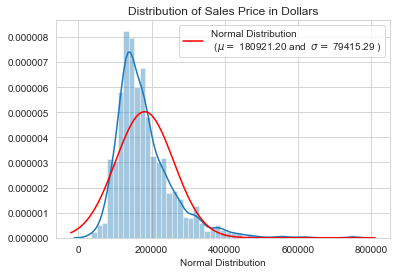

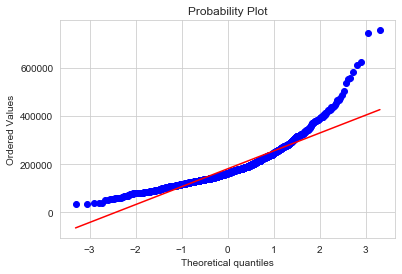

In [7]:
sns.set_style('whitegrid')
sns.distplot(all_data['SalePrice'][~all_data['SalePrice'].isnull()], axlabel="Normal Distribution", fit=st.norm, fit_kws={"color":"red"})
plt.title('Distribution of Sales Price in Dollars')
(mu, sigma) = st.norm.fit(train['SalePrice'])
plt.legend(['Normal Distribution \n ($\mu=$ {:.2f} and  $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best', fancybox=True)
plt.show()

st.probplot(all_data['SalePrice'][~all_data['SalePrice'].isnull()], plot=plt)
plt.show()

Linear models tend to work better with normally distributed data. As such, we need to transform the response variable to make it more normally distributed.

## 4.2 Log-Transformation of the Response Variable

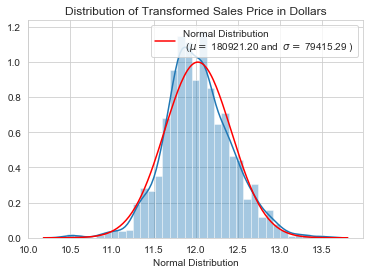

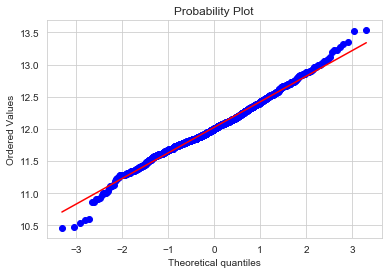

In [8]:
all_data['SalePrice'] = np.log1p(all_data['SalePrice'])

sns.distplot(all_data['SalePrice'][~all_data['SalePrice'].isnull()], axlabel="Normal Distribution", fit=st.norm, fit_kws={"color":"red"})

plt.title('Distribution of Transformed Sales Price in Dollars')
(mu, sigma) = st.norm.fit(train['SalePrice'])
plt.legend(['Normal Distribution \n ($\mu=$ {:.2f} and  $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best', fancybox=True)
plt.show()

st.probplot(all_data['SalePrice'][~all_data['SalePrice'].isnull()], plot=plt)
plt.show()

The skew is highly corrected and the distribution of the log-transformed sale prices appears more normally distributed.

# 5 Data Imputation

## 5.1 Completeness of the Data

We first need to find which variables contain missing values.

In [9]:
cols_with_missing_values = all_data.isnull().sum().sort_values(ascending=False)
display(pd.DataFrame(cols_with_missing_values[cols_with_missing_values[cols_with_missing_values > 0].index], 
                     columns=["Number of Missing Values"]))

,Number of Missing Values
PoolQC,2909
MiscFeature,2814
Alley,2721
Fence,2348
SalePrice,1459
FireplaceQu,1420
LotFrontage,486
GarageFinish,159
GarageQual,159
GarageYrBlt,159


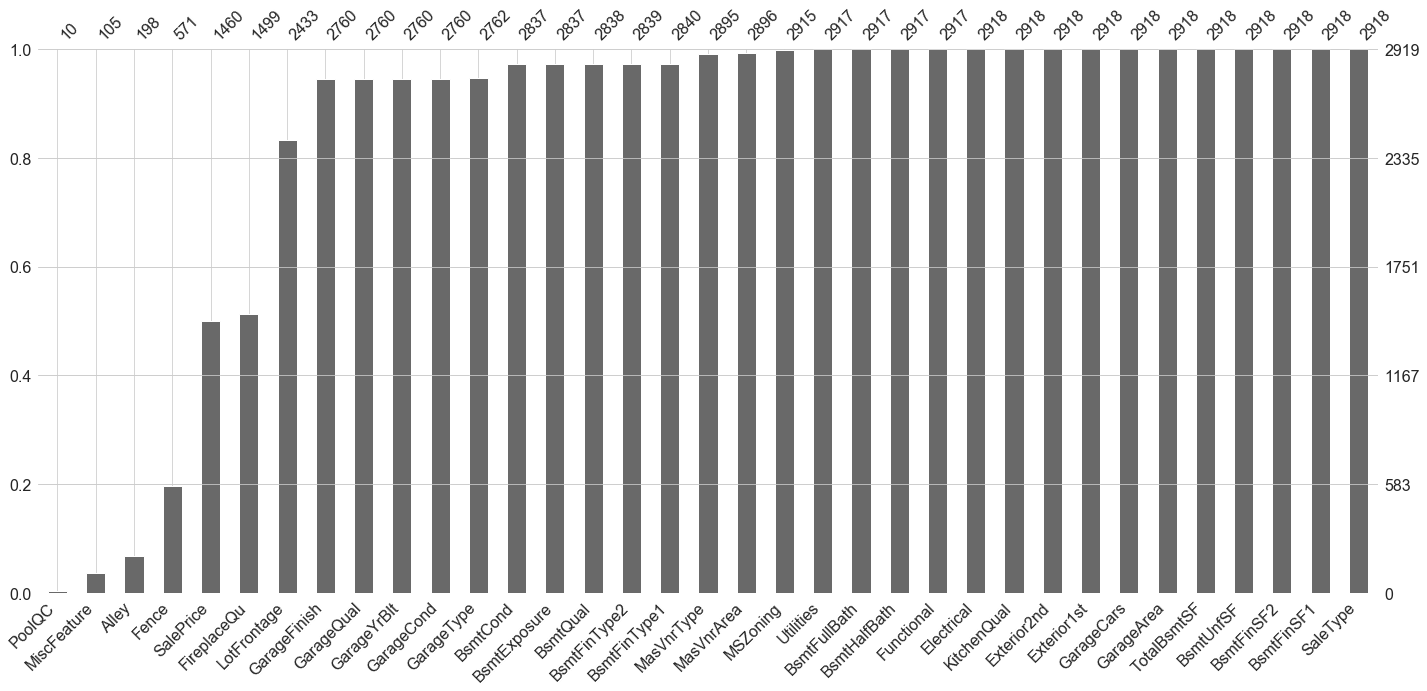

In [10]:
cols_with_missing_values = all_data.isnull().sum().sort_values(ascending=False)
cols_with_missing_values = all_data[cols_with_missing_values[cols_with_missing_values > 0].index]
msno.bar(cols_with_missing_values)
plt.show()

##  5.2 Impute the Missing Data

### 5.2.1 Missing Values Corresponding to Lack of Specific Feature

* <b>PoolQC</b>: data description of the variables states that NA represents "no pool". This makes sense given the vast number of missing values (>99%) and that a majority of houses do not have a pool.

In [11]:
all_data['PoolQC'].replace(np.nan, 'None', regex=True, inplace=True)

* <b>MiscFeature</b>: data description of the variables states that NA represents "no miscellaneous feature". 

In [12]:
all_data['MiscFeature'].replace(np.nan, 'None', regex=True, inplace=True)

* <b>Alley</b>: data description of the variables states that NA represents "no alley access". 

In [13]:
all_data['Alley'].replace(np.nan, 'None', regex=True, inplace=True)

* <b>Fence</b>: data description of the variables states that NA represents "no fence". 

In [14]:
all_data['Fence'].replace(np.nan, 'None', regex=True, inplace=True)

* <b>FireplaceQU</b>: data description of the variables states that NA represents "no fireplace". 

In [15]:
all_data['FireplaceQu'].replace(np.nan, 'None', regex=True, inplace=True)

* <b>GarageType, GarageFinish, GarageQual, and GarageCond</b>: Missing values are likely due to lack of a garage. Replacing missing data with None.

In [16]:
garage_categorical = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
for variable in garage_categorical:
    all_data[variable].replace(np.nan, 'None', regex=True, inplace=True)

* <b>GarageYrBlt, GarageCars, and GarageArea</b>: Missing values are likely due to lack of a basement. Replacing missing data with 0 (since no garage means no cars in a garage).

In [17]:
garage_numeric = ['GarageYrBlt', 'GarageCars', 'GarageArea']
for variable in garage_numeric:
    all_data[variable].replace(np.nan, 0, regex=True, inplace=True)

* <b>BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, and BsmtFinType2</b>: Missing values are likely due to lack of a basement.  Replacing missing data with None.

In [18]:
basement_categorical = ['BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
for variable in basement_categorical:
    all_data[variable].replace(np.nan, 'None', regex=True, inplace=True)

* <b>BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, and BsmtHalfBath</b>: Missing values are likely due to lack of a basement. Replacing missing data with 0.

In [19]:
basement_numeric = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
for variable in basement_numeric:
    all_data[variable].replace(np.nan, 0, regex=True, inplace=True)

* <b>MasVnrType and MasVnrArea</b>: Missing values are likely due to lack of masonry vaneer. We will replace the missing values with None for the type and 0 for the area.

In [20]:
all_data['MasVnrType'].replace(np.nan, 'None', regex=True, inplace=True)
all_data['MasVnrArea'].replace(np.nan, 0, regex=True, inplace=True)

* <b>Functional</b>: data description of the variables states that NA represents "typical".

In [21]:
all_data['Functional'].replace(np.nan, 'Typ', regex=True, inplace=True)

### 5.2.2 Mode Imputation: Replacing Missing Values with Most Frequent Value

Using a mode imputation, we replace the missing values of a categorical variable with the mode of the non-missing cases of that variable. While it does have the advantage of being fast, it comes at the cost of a reduction in variance within the dataset.

Due to the low number of missing values imputed using this method, the bias introduced on the mean and standard deviation, as well as correlations with other variables are minimal.

<br>

First, we define a function "<b>mode_impute_and_plot</b>" to simplify the process of visualizing the categorical variables and replacing the missing variables with the most frequent value.

In [22]:
def mode_impute_and_plot(variable):
    print('# of missing values: ' + str(all_data[variable].isna().sum()))
    plt.figure(figsize=(8,4))
    ax = sns.countplot(all_data[variable])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.show()
    
    all_data[variable].replace(np.nan, all_data[variable].mode()[0], regex=True, inplace=True)

Now we can proceed to replace the missing values for the following variables:

[]()  | 
------|------
[MSZoning](#MSZoning) | [Utilities](#Utilities) | [Electrical](#Electrical) | [Exterior1st and Exterior2nd](#Exterior1st and Exterior2nd) | [KitchenQual](#KitchenQual) | [SaleType](#SaleType)

<a id="MSZoning"></a>

* <b>MSZoning</b>: "RL" is by far the most common value. Missing values will be replace with "RL".

# of missing values: 4


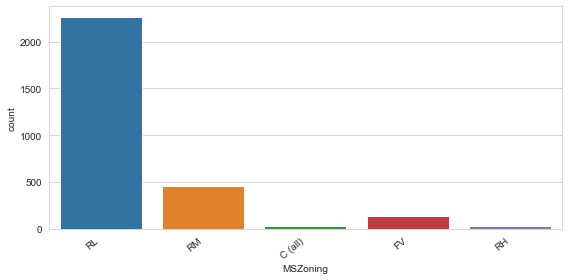

In [23]:
mode_impute_and_plot('MSZoning')

<a id="Utilities"></a>

* <b>Utilities</b>: With the exception of one "NoSeWa" value, all records for this variable are "AllPub". Since "NoSeWa" is only in the training set, <b>this feature will not help in predictive modelling</b>. As such, we can safely remove it.

# of missing values: 2


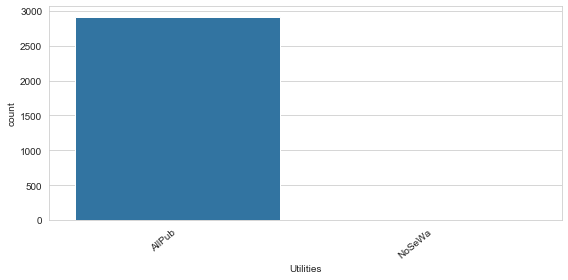

In [24]:
mode_impute_and_plot('Utilities')

all_data = all_data.drop('Utilities', axis=1)

<a id="Electrical"></a>

* <b>Electrical</b>: Only one missing value, replace it with "SBrkr", the most common value.

# of missing values: 1


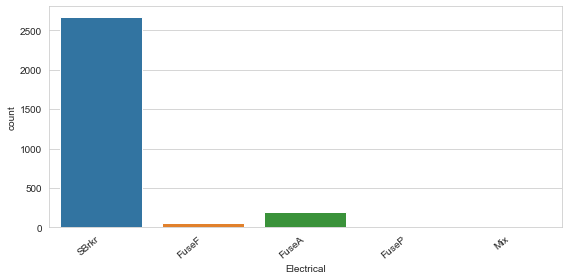

In [25]:
mode_impute_and_plot('Electrical')

<a id="Exterior1st and Exterior2nd"></a>

* <b>Exterior1st and Exterior2nd</b>: There is only one missing value for both Exterior 1 & 2. Missing values will be replaced by the most common value.

# of missing values: 1


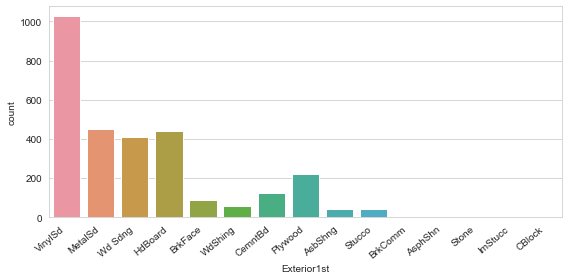

In [26]:
mode_impute_and_plot('Exterior1st')

# of missing values: 1


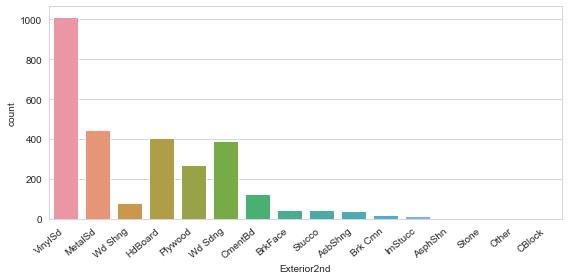

In [27]:
mode_impute_and_plot('Exterior2nd')

<a id="KitchenQual"></a>

* <b>KitchenQual</b>: Only one missing value, replace it with "TA", the most common value.

# of missing values: 1


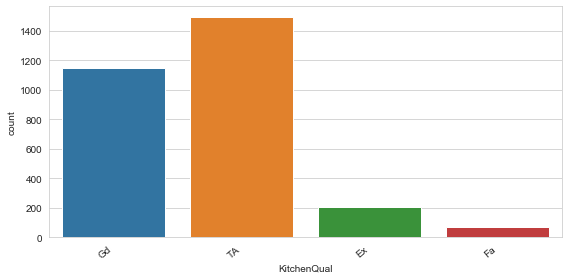

In [28]:
mode_impute_and_plot('KitchenQual')

<a id="SaleType"></a>

* <b>SaleType</b>: Replace missing values with "WD", the most common value.

# of missing values: 1


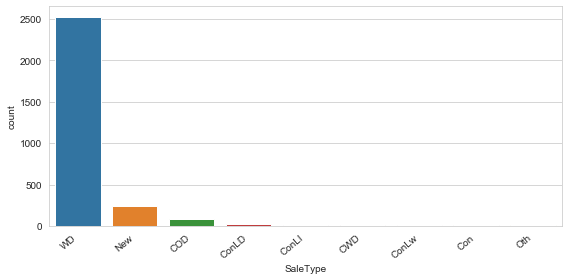

In [29]:
mode_impute_and_plot('SaleType')

Are there any remaining missing values?

In [30]:
cols_with_missing_values = all_data.isnull().sum().sort_values(ascending=False)
display(pd.DataFrame(cols_with_missing_values[cols_with_missing_values[cols_with_missing_values > 0].index], columns=["Number of Missing Values"]))


,Number of Missing Values
SalePrice,1459
LotFrontage,486


Due to its numeric nature and the large number of missing values, the  LotFrontage variable will be imputed separately using an SVM algorithm (See Section [7 LotFrontage Imputation](#7-Lot-Frontage-Imputation)). 

<br>
The remaining variables are all complete! Now to move on to feature engineering.

# 6 Feature Engineering

## 6.1 Mixed Conditions

In order to simplify and boost the accuracy of the preditive models, we will merge the two conditions into one variable: <b>MixedConditions</b>

The data descriptions states:
* <b>Condition1</b> represents proximity to various conditions.
* <b>Condition2</b> represents proximity to various conditions (if more than one is present).

If a property does not have one or multiple conditions, then it is classified as normal. However, designation of "normal" are condition 1 or condition 2 is strictly alphabetical.

For example, if a property is in proximity to a feeder street ("Feedr") and no other condition, then the data would appear as follows:

Condition1 | Condition2
-----------|-------------
    Feedr  |    Norm

<br>
    
However, if a property is within 200' of East-West Railroad (RRNe) and no other condition, then the data would appear as follows:

Condition1 | Condition2
-----------|-------------
    Norm   |    RRNe


<br><br>

Once we merge Conditions 1 & 2 into the <b>MixedConditions</b> variable, we will remove them from the analysis.

In [31]:
all_data['MixedConditions'] = all_data['Condition1'] + ' - ' + all_data['Condition2']
all_data.drop(labels=['Condition1', 'Condition2'], axis=1, inplace=True)

## 6.2 Mixed Exterior
The Exterior1st and Exterior2nd features are similar to the Conditions feature we merged and remove above. Properties with multiple types of exterior covering the house are assigned to Exterior1st or Exterior2nd alphabetically.

As such, we will conduct the same process to merge the two columns into a single <b>MixedExterior</b> variable and remove them from the analysis.

In [32]:
all_data['MixedExterior'] = all_data['Exterior1st'] + ' - ' + all_data['Exterior2nd']
all_data.drop(labels=['Exterior1st', 'Exterior2nd'], axis=1, inplace=True)

## 6.3 Total Square Feet
One of the important factors that people consider when buying a house is the total living space in square feet. Since the total square feet is not explicitly listed, we will add a new variable by adding up the square footage of the basement, first floor, and the second floor.

In [33]:
SF_df = all_data[['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'SalePrice']]
SF_df = SF_df[~SF_df['SalePrice'].isnull()]
SF_vars = list(SF_df)
del SF_vars[-1]

SF_summary = []

for SF_type in SF_vars:
    corr_val = np.corrcoef(SF_df[SF_type], SF_df['SalePrice'])[1][0]
    SF_summary.append(corr_val)
    
pd.DataFrame([SF_summary], columns=SF_vars, index=['SalePrice Correlation'])

,TotalBsmtSF,1stFlrSF,2ndFlrSF
SalePrice Correlation,0.612134,0.596981,0.3193


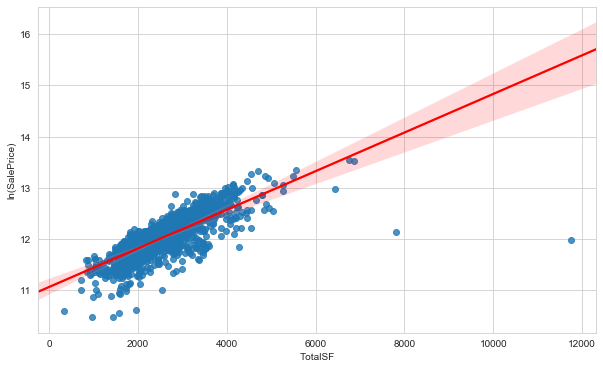

Pearson Correlation Coefficient: 0.782


In [34]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

plt.figure(figsize=(10,6))
ax = sns.regplot(all_data['TotalSF'], all_data['SalePrice'], line_kws={'color': 'red'})
ax.set(ylabel='ln(SalePrice)')
plt.show()

print("Pearson Correlation Coefficient: %.3f" %  (np.corrcoef(all_data['TotalSF'].iloc[:ntrain], train['SalePrice']))[1][0])

There is a very strong correlation (r = 0.78) between the TotalSF and the SalePrice, with the exception of two outliers. These outliers should be removed to increase the accuracy of our model.

## 6.4 Total Number of Bathrooms

There are 4 bathroom variables. Individually, these variables are not very important. Together, however, these predictors are likely to become a strong one.

A full bath is made up of four parts: a sink, shower, a bathtub, and a toilet. A half-bath, also called a powder room or guest bath, only has a sink and a toilet. As such, half-bathrooms will have half the value of a full bath. 

In [35]:
bath_df = all_data[['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'SalePrice']]
bath_df = bath_df[~bath_df['SalePrice'].isnull()]
bath_vars = list(bath_df)
del bath_vars[-1]

bath_summary = []

for bath_type in bath_vars:
    corr_val = np.corrcoef(bath_df[bath_type], bath_df['SalePrice'])[1][0]
    bath_summary.append(corr_val)
    
pd.DataFrame([bath_summary], columns=bath_vars, index=['SalePrice Correlation'])

,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath
SalePrice Correlation,0.236224,-0.005149,0.594771,0.313982


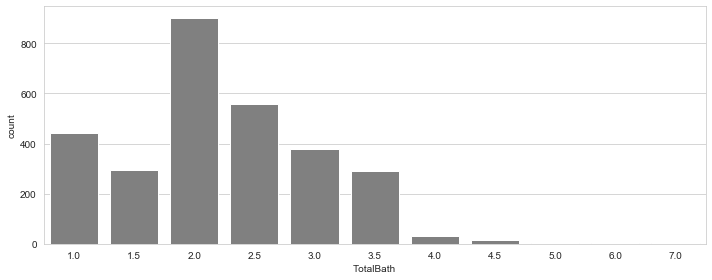

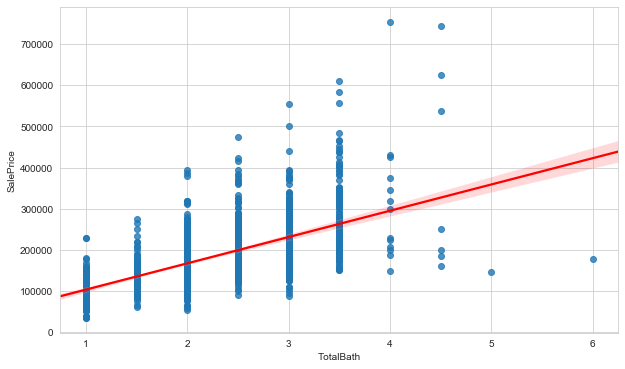

Pearson Correlation Coefficient: 0.632


In [36]:
all_data['TotalBath'] = all_data['BsmtFullBath'] + (all_data['BsmtHalfBath']*0.5) + all_data['FullBath'] + (all_data['HalfBath']*0.5)

plt.figure(figsize=(10,4))
sns.countplot(all_data['TotalBath'], color='grey')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.regplot(all_data['TotalBath'].iloc[:ntrain], train['SalePrice'], line_kws={'color': 'red'})
ax.set(ylabel='ln(SalePrice)')
plt.show()

print("Pearson Correlation Coefficient: %.3f" %  (np.corrcoef(all_data['TotalBath'].iloc[:ntrain], train['SalePrice']))[1][0])

We can see a high positive correlation (r = 0.67) between TotalBath and SalePrice. The new variable correlation is much higher than any of the four original bathroom variables.

## 6.5 Binning the Neighbourhoods

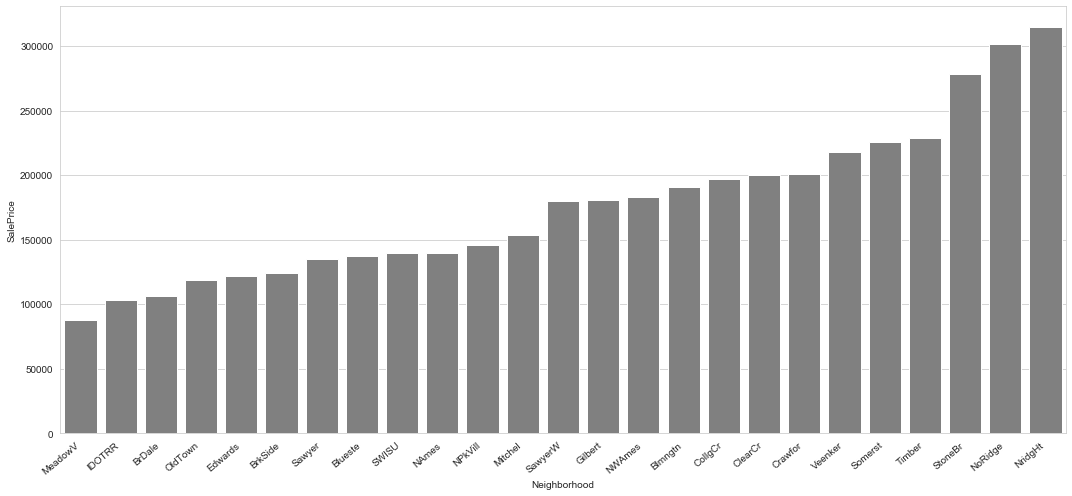

In [37]:
neighborhood_prices = all_data.iloc[:ntrain].copy()
neighborhood_prices['SalePrice'] = np.exp(all_data['SalePrice'])
neighborhood_prices = neighborhood_prices[['Neighborhood', 'SalePrice']].groupby('Neighborhood').median().sort_values('SalePrice')

plt.figure(figsize=(15,7))
ax = sns.barplot(x= neighborhood_prices.index, y=neighborhood_prices['SalePrice'], color='grey')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In order to bin the neighbourhoods into approriate clusters, we will use K-Mean clustering. <b>K-Means</b> is an unsupervised machine learning algorithm that groups a dataset into a user-specified number (<i>k</i>) of clusters. One potential issue with the algorithm is that it will cluster the data into <i>k</i> clusters, even if <i>k</i> is not the right number of cluster to use.

Therefore, we need to identity the optimal number of k clusters to use. To do so, we will use the <i>Elbow Method</i>. 

Briefly, the idea of the elbow method is to run k-means clustering for a range of values and calculate the sum of squared errors (SSE). We then plot a line chart of the SSE for each value of <i>k</i>. Each additional <i>k</i> cluster will result in a lower SSE, but will eventually exhibit significantly diminished return. 

The goal is the choose a small value of k with a low SSE, after which the subsequent k values exhibit diminishing returns. If the line plot looks like an arm, then the "elbow" of the arm is the optimal <i>k</i> value. 

The plot below indicates that the optimal number of neighbourhood clusters is <i>k</i> = 3.

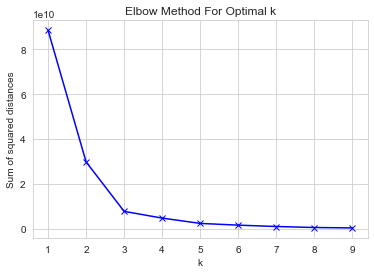

In [38]:
SS_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(neighborhood_prices)
    SS_distances.append(km.inertia_)
    

plt.plot(K, SS_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Now let's see how the binned neighborhoods look like.

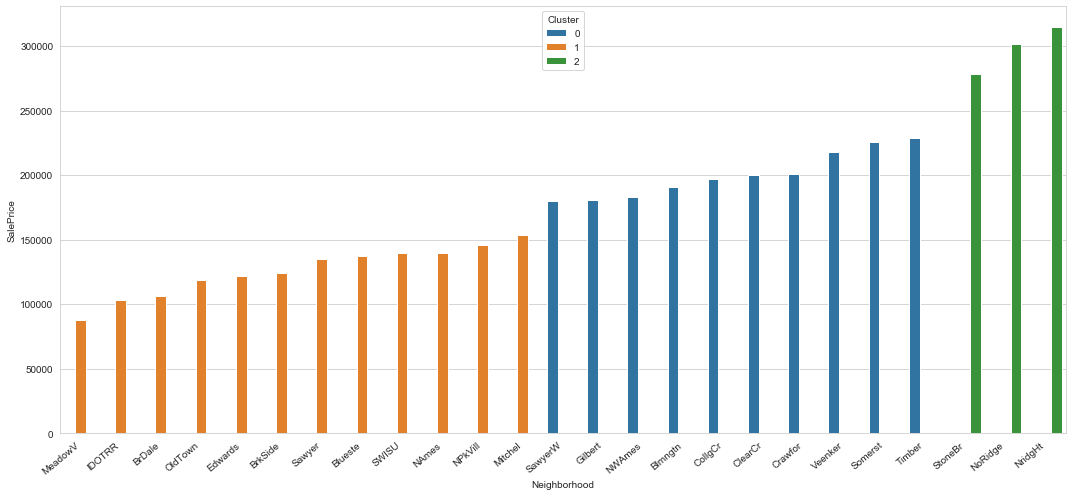

In [39]:
neighborhood_prices['Cluster'] = KMeans(n_clusters=3).fit(neighborhood_prices).labels_

plt.figure(figsize=(15,7))
ax = sns.barplot(x= neighborhood_prices.index, y=neighborhood_prices['SalePrice'], 
                 hue=neighborhood_prices['Cluster'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

Lastly, we have to create a new variable in the dataset based on the new cluster labels.

In [40]:
neighborhood_dict = dict(zip(neighborhood_prices.index, neighborhood_prices.Cluster))
all_data['Neighborhood_Class'] = all_data['Neighborhood']
all_data['Neighborhood_Class'].replace(neighborhood_dict, inplace = True)

# 7 LotFrontage Imputation

Due to the numeric nature and sheer number of missing values in the <i>LotFrontage</i> column, we will impute the missing values using an SVM Regressor algorithm to predict the missing values.

The first step is to subset the dataset into two groups. The <i>train</i> dataset (train_LotFrontage) contains the complete records while the <i>test</i> dataset (test_LotFrontage) contains the missing values. Next, we examine the structure of the newly created datasets. There are 486 missing values in the full dataset, or roughly 16% of the data.

## 7.1 LotFrontage Data Structure

In [41]:
train_LotFrontage = all_data[~all_data.LotFrontage.isnull()]
test_LotFrontage = all_data[all_data.LotFrontage.isnull()]

print("Dimensions of Train LotFrontage Dataset:" + str(train_LotFrontage.shape))
print("Dimensions of Test LotFrontage Dataset:" + str(test_LotFrontage.shape))
display(pd.DataFrame(all_data['LotFrontage'].describe()).transpose())

Dimensions of Train LotFrontage Dataset:(2433, 81)
Dimensions of Test LotFrontage Dataset:(486, 81)


,count,mean,std,min,25%,50%,75%,max
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0


Now let's examine the distribution of LotFrontages values in the Train LotFrontage dataset through a boxplot and distribution plot. Through these graphs, we can see several interesting observations appear:
* There is a cluster of low <i>LotFrontage</i> value properties, shown as a peak on the far left of the distribution plot. The boxplot indicates these values may be outliers, shown as outlier points on the left of the whisker of the boxplot.
* There is a long tail of high <i>LotFrontage</i> value properties. These values extend beyond the Median + 1.5IQR  range.

In other words, there are outliers on both ends of the <i>LotFrontage</i> value distributions.

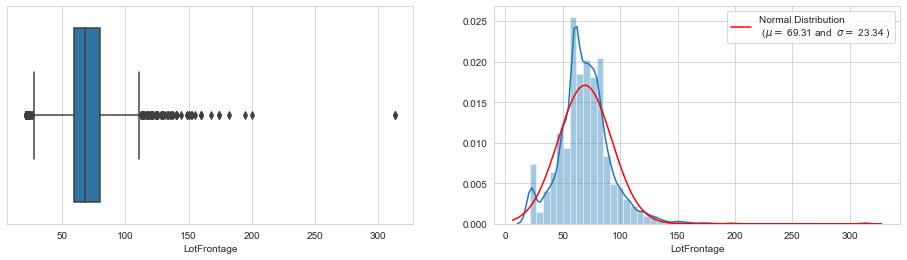

In [42]:
fig, ax = plt.subplots(1,2, figsize=(16,4))
sns.boxplot(train_LotFrontage['LotFrontage'], ax=ax[0])

sns.distplot(train_LotFrontage['LotFrontage'], ax=ax[1], fit=st.norm, fit_kws={"color":"red"})
(mu, sigma) = st.norm.fit(train_LotFrontage['LotFrontage'])
plt.legend(['Normal Distribution \n ($\mu=$ {:.2f} and  $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best', fancybox=True)
plt.show()

## 7.2 Outlier Detection & Removal
Before we examine the correlations between <i>LotFrontage</i> and other variables, we should remove the outliers seen above. 

To do so, we will use the Interquartile Range (IQR) method, where values outside the <i>Median ± 1.5IQR</i> are considered to be outliers. These outliers are then removed from the <i>LotFrontage</i> datasets.

In [43]:
def outlier_detection(data):
    Q1, Q3 = np.percentile(data, [25,75])
    IQR = Q3-Q1
    lower_cutoff = Q1 - (IQR * 1.5)
    upper_cutoff = Q3 + (IQR * 1.5)
    outliers = (data > Q3+1.5*IQR) | (data < Q1-1.5*IQR)
    return outliers

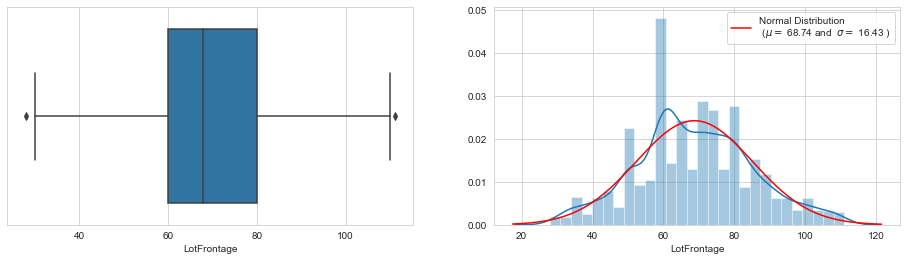

In [44]:
train_LotFrontage_no_outliers = train_LotFrontage[~outlier_detection(train_LotFrontage.LotFrontage)]
fig, ax = plt.subplots(1,2, figsize=(16,4))
sns.boxplot(train_LotFrontage_no_outliers['LotFrontage'], ax=ax[0])

sns.distplot(train_LotFrontage_no_outliers['LotFrontage'], ax=ax[1], fit=st.norm, fit_kws={"color":"red"})
(mu, sigma) = st.norm.fit(train_LotFrontage_no_outliers['LotFrontage'])
plt.legend(['Normal Distribution \n ($\mu=$ {:.2f} and  $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best', fancybox=True)
plt.show()

Two new values previously not deemed outliers by the first iteration of the IQR range method are now shown as potential outliers in the boxplot. This is caused by having a new smaller IQR value after removing the first batch of outliers. As such, we will keep these values.

## 7.3 Determining Relevant Variables of LotFrontage
Now we can explore the relationship between the <i>LotFrontage</i> target variable and other features. In order to confirm a relationship between these key features and we will conduct an <b>ANOVA</b> (Analysis of Variance) test to determine statistical significance (in this case, <i>p < 0.01</i>).


<br>
Using the type III ANOVA, we are confident the variables listed in the table below are correlated with LotFrontage.

* Note:  Variables that begin with a number (<i>1stFlrSF</i>, <i>2ndFlrSF</i>, and <i>3SsnPorch</i>) cause a syntax error within the ols formula input. I briefly converted them to an appropriate name in the <i>temp_train</i> dataset for the purpose of the ANOVA.

In [45]:
temp_train = train_LotFrontage_no_outliers.copy()
temp_train.rename(columns={'1stFlrSF':'X1stFlrSF', '2ndFlrSF': 'X2ndFlrSF', '3SsnPorch': 'X3SsnPorch'}, inplace=True)

mod = ols('LotFrontage ~ X1stFlrSF + X2ndFlrSF + X3SsnPorch + Alley + BedroomAbvGr + BldgType + BsmtCond + BsmtExposure + BsmtFinSF1 + BsmtFinSF2 + BsmtFinType1 + BsmtFinType2 + BsmtFullBath + BsmtHalfBath + BsmtQual + BsmtUnfSF + CentralAir + Electrical + EnclosedPorch + ExterCond + ExterQual + Fence + FireplaceQu + Fireplaces + Foundation + FullBath + Functional + GarageArea + GarageCars + GarageCond + GarageFinish + GarageQual + GarageType + GarageYrBlt + GrLivArea + HalfBath + Heating + HeatingQC + HouseStyle + KitchenAbvGr + KitchenQual + LandContour + LandSlope + LotArea + LotConfig + LotShape + LowQualFinSF + MSSubClass + MSZoning + MasVnrArea + MasVnrType + MiscFeature + MiscVal + MoSold + Neighborhood + OpenPorchSF + OverallCond + OverallQual + PavedDrive + PoolArea + PoolQC + RoofMatl + RoofStyle + SaleCondition + SaleType + ScreenPorch + Street + TotRmsAbvGrd + TotalBsmtSF + WoodDeckSF + YearBuilt + YearRemodAdd + YrSold + MixedConditions + MixedExterior + TotalSF + TotalBath + Neighborhood_Class', data=temp_train).fit()
aov_table = sm.stats.anova_lm(mod, typ=3)
display(aov_table[aov_table['PR(>F)'] < 0.01])

,sum_sq,df,F,PR(>F)
Alley,1363.913911,2.0,7.503367,5.674399e-04
BldgType,20479.667110,4.0,56.332901,5.337216e-45
GarageCond,1600.666924,5.0,3.522331,3.573473e-03
GarageFinish,1607.144665,3.0,5.894309,5.300349e-04
GarageQual,1851.155770,5.0,4.073542,1.108720e-03
GarageType,4398.086327,6.0,8.065136,1.269477e-08
HouseStyle,3641.202949,7.0,5.723294,1.433756e-06
LotConfig,43527.367185,4.0,119.729624,2.398118e-91
LotShape,2826.722888,3.0,10.367193,9.089207e-07
Neighborhood,14742.824462,23.0,7.052646,7.333663e-22


## 7.4 LotFrontage Model Building and Evaluation
Now let's build a model using the relevant variables selected above. We will be using Support Vector Regressor to build the model.

The first step is to seperate the target variable, <i>LotFrontage</i>, select the relevant variables, and dummifying the categorical variables.

In [46]:
X = train_LotFrontage_no_outliers[aov_table[aov_table['PR(>F)'] < 0.01].index]
y = train_LotFrontage_no_outliers['LotFrontage']

X = pd.get_dummies(X)
transformer = StandardScaler().fit(X)
X = transformer.transform(X)

In order to determine the accuracy of our predictive model, we will create a <i>Validation</i> dataset. This dataset will have known values for the target <i>LotFrontage</i> variable which can we compare our model's prediction against. Using the mean absolute error, we can measure the difference between our predicted <i>LotFrontage</i> values with the true values.

<img src="https://i.imgur.com/jswcCd8.png">

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234)

clf = svm.SVR(kernel='rbf', C=100, gamma=0.001)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print('Mean Absolute Error:  %.3f' % mean_absolute_error(y_test, preds))

Mean Absolute Error:  6.848


These results show that using the SVR model to impute <i>LotFrontage</i> gives an average rror of less than 7 feet.

We will now use the same SVR model to predict the unknown <i>LotFrontage</i> values in the test_Frontage dataset.

In [48]:
model_data = train_LotFrontage_no_outliers.copy()
model_data= model_data.append(test_LotFrontage)
y = model_data['LotFrontage']
model_data = model_data[['MSZoning', 'Alley', 'LotArea', 'LotShape', 'LotConfig', 'Neighborhood', 'MixedConditions', 'GarageType', 'GarageCars', 'GarageArea']]

model_data = pd.get_dummies(model_data)
model_X_train = model_data[~y.isnull()]
model_X_test = model_data[y.isnull()]
model_y_train = y[~y.isnull()]

transformer = StandardScaler().fit(model_X_train)
model_X_train = transformer.transform(model_X_train)
model_X_test = transformer.transform(model_X_test)

clf = svm.SVR(kernel='rbf', C=100, gamma=0.001)
clf.fit(model_X_train, model_y_train)
LotFrontage_preds = clf.predict(model_X_test)

Now that we have the newly predicted <i>LotFrontage</i> values, we can examine the distribution of predicted values relative to the known <i>LotFrontage</i> values in the training dataset. Both distributions have a mean around 70 feet with similar tail lengths on either end. 

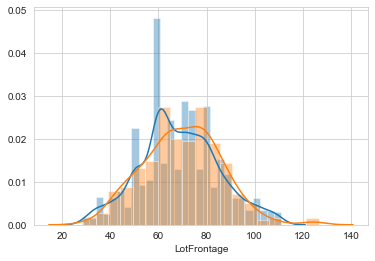

In [49]:
sns.distplot(model_y_train)
sns.distplot(LotFrontage_preds)

Lastly, we need to add the predicted values back into the original dataset.

In [50]:
all_data.LotFrontage[all_data.LotFrontage.isnull()] = LotFrontage_preds

C:\Users\AnuragMishra\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# 8 Preparing the Data for Modelling

## 8.1 Removing Outliers
Although we could be more in depth in our outliet detection and removal, we are only going to remove the two outliers found in the TotalSF variable. These properties exhibited large total square feet values with low SalePrice.

In [51]:
all_data.drop(all_data['TotalSF'].iloc[:ntrain].nlargest().index[:2], axis=0, inplace=True)    
ntrain = train.shape[0]-2

## 8.2 Correlation Between Numeric Predictors

We can see a large correlation between many variables, suggesting a high level of multicollinearity. There are two options to consider:
1. Use a regression model that deals well with multicollinearity, such as a ridge regression.
2. Remove highly correlated predictors from the model.

TypeError: object of type <class 'float'> cannot be safely interpreted as an integer.

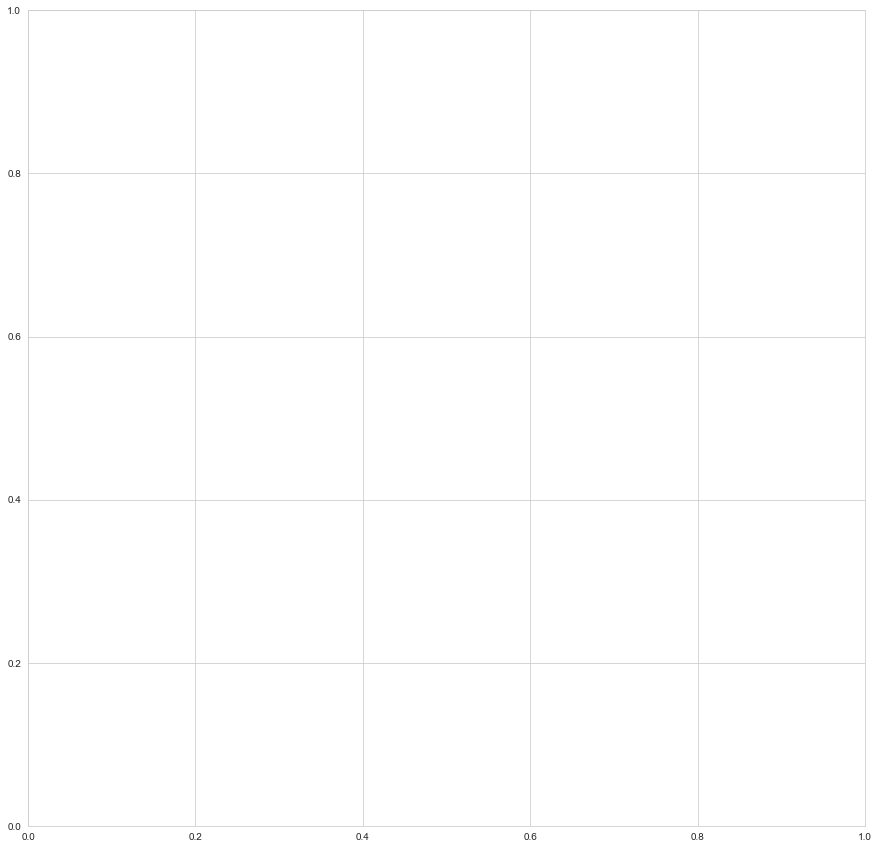

In [52]:
corr = all_data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap,
            center=0, square=True, linewidths = .5)
plt.show()

## 8.3 Label Encoding
Many of the ordinal variables are presented as numeric values. Therefore we need to label encode these numeric characters into strings.

In [ ]:
num_to_str_columns = ['MSSubClass', 'OverallQual', 'OverallCond', 'MoSold', 'YrSold']

for col in num_to_str_columns:
    all_data[col] = all_data[col].astype('str')

In [53]:
cat_cols = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
            'BsmtFinType2', 'BsmtFinSF2', 'HeatingQC', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 
            'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageFinish', 'GarageCars',
            'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']

for col in cat_cols:
    label = LabelEncoder()
    label.fit(list(all_data[col].values))
    all_data[col] = label.transform(list(all_data[col].values))

print('Shape all_data: {}'.format(all_data.shape))
all_data.head()

Shape all_data: (2917, 81)


,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,Dataset,MixedConditions,MixedExterior,TotalSF,TotalBath,Neighborhood_Class
0,856,854,0,None,3,1Fam,4,3,706.0,0,...,0,110,53,2,Train,Norm - Norm,VinylSd - VinylSd,2566.0,3.5,0
1,1262,0,0,None,3,1Fam,4,1,978.0,0,...,298,83,26,1,Train,Feedr - Norm,MetalSd - MetalSd,2524.0,2.5,0
2,920,866,0,None,3,1Fam,4,2,486.0,0,...,0,108,52,2,Train,Norm - Norm,VinylSd - VinylSd,2706.0,3.5,0
3,961,756,0,None,3,1Fam,1,3,216.0,0,...,0,25,20,0,Train,Norm - Norm,Wd Sdng - Wd Shng,2473.0,2.0,0
4,1145,1053,0,None,4,1Fam,4,0,655.0,0,...,192,107,50,2,Train,Norm - Norm,VinylSd - VinylSd,3343.0,3.5,2


## 8.4 Skewness & Normalization of Numeric Variables

<b>Skewness</b> is a measure of asymmetry of a distribution, and can be used to define the extent to which the distribution differs from a normal distribution. Therefore, a normal distribution will have a skewness of 0. As a rule of thumb, if skewness is less than -1 or greater than 1, the distribution is highly skewed. 

In order to account for skewness, we will transform the (highly) skewed data into normality using a Log Transformation. We define highly skewed data as variables with a skewness greater than 0.85. This method is similar to the approach used to normalize the [SalePrice Response Variable](#4.2-Log-Transformation-of-the-Response-Variable), except we will use log+1 to avoid division by zero issues.

In [54]:
numeric_feats = ['LotFrontage', 'LotArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
                 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
                 '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'TotalSF']

skewed_feats = all_data[numeric_feats].apply(lambda x: st.skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew Before Transformation' :skewed_feats})

skewness = skewness[abs(skewness) > 1].dropna(axis=0)
skewed_features = skewness.index
for feat in skewed_features:
    all_data[feat] = np.log1p(all_data[feat]+1)

skewed_feats = all_data[skewed_features].apply(lambda x: st.skew(x.dropna())).sort_values(ascending=False)
skewness['Skew After Transformation'] = skewed_feats
skewness

,Skew Before Transformation,Skew After Transformation
MiscVal,21.939672,5.255296
PoolArea,17.688664,15.655054
LotArea,13.109495,-0.532117
LowQualFinSF,12.084539,8.605557
3SsnPorch,11.372080,8.853408
EnclosedPorch,4.002344,1.983518
ScreenPorch,3.945101,2.954087
OpenPorchSF,2.529358,0.019004
WoodDeckSF,1.844792,0.179665
1stFlrSF,1.257286,0.031286


## 8.5 One Hot Encoding the Categorical Variables
The last step needed to prepare the data is to make sure that all categorical predictor variables are converted into a form that is usable by machine learning algorithms. This process is known as 'one-hot encoding' the categorical variables.

The process involved all non-ordinal factors receiving their own separate column with 1's and 0's, and is required by most ML algorithms.

In [55]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)
all_data.head(3)

(2917, 302)


,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,...,MixedExterior_Wd Sdng - Stone,MixedExterior_Wd Sdng - Stucco,MixedExterior_Wd Sdng - VinylSd,MixedExterior_Wd Sdng - Wd Sdng,MixedExterior_Wd Sdng - Wd Shng,MixedExterior_WdShing - HdBoard,MixedExterior_WdShing - Plywood,MixedExterior_WdShing - Stucco,MixedExterior_WdShing - Wd Sdng,MixedExterior_WdShing - Wd Shng
0,6.754604,854,0.693147,3,4,3,706.0,0,2,6,...,0,0,0,0,0,0,0,0,0,0
1,7.142037,0,0.693147,3,4,1,978.0,0,0,6,...,0,0,0,0,0,0,0,0,0,0
2,6.826545,866,0.693147,3,4,2,486.0,0,2,6,...,0,0,0,0,0,0,0,0,0,0


# 9 SalePrice Modelling
Now that the data is correctly processed, we are ready to begin building our predictive models. 

## 9.1 Obtaining Final Train and Test Sets

In [56]:
final_y_train = all_data['SalePrice'][~all_data['SalePrice'].isnull()]
final_X_train = all_data[all_data['Dataset_Train'] == 1].drop(['Dataset_Train', 'Dataset_Test', 'SalePrice'], axis=1)
final_X_test = all_data[all_data['Dataset_Test'] == 1].drop(['Dataset_Train', 'Dataset_Test', 'SalePrice'], axis=1)
final_X_train.shape

(1458, 299)

## 9.2 Defining a Cross Validation Strategy
We will use the [cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function of Sklearn and calculate the Root-Mean-Squared Error (RMSE) as a measure of accuracy.

In [57]:
n_folds = 10

def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=1234).get_n_splits(final_X_train.values)
    rmse= np.sqrt(-cross_val_score(model, final_X_train.values, final_y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## 9.3 Lasso Regression Model

This model may be senstitive to outliers, so we need to make it more robust. This will be done using the <b>RobustScaler</b> function on pipeline.

In [58]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005, random_state = 1234))

Next, we tested out multiple alpha values and compared their accuracy using the <b>rmse_cv</b> function above. The results below show that using a value of 0.00025 is the optimal value of alpha for a Lasso Regression.

,1.00000,0.50000,0.25000,0.10000,0.05000,0.02500,0.01000,0.00500,0.00250,0.00100,0.00050,0.00025,0.00010
RMSE,0.398841,0.398841,0.339897,0.224745,0.172852,0.148434,0.129269,0.123468,0.117232,0.110457,0.108669,0.108335,0.10975


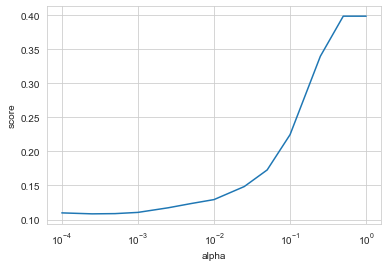


Lasso Score: 0.1083 (alpha = 0.00025)



In [59]:
lasso_alpha = [1, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001, 0.0005, 0.00025, 0.0001]
lasso_rmse = []

for value in lasso_alpha:
    lasso = make_pipeline(RobustScaler(), Lasso(alpha = value, max_iter=3000, random_state = 1234))
    lasso_rmse.append(rmse_cv(lasso).mean())
    
lasso_score_table = pd.DataFrame(lasso_rmse,lasso_alpha,columns=['RMSE'])
display(lasso_score_table.transpose())

plt.semilogx(lasso_alpha, lasso_rmse)
plt.xlabel('alpha')
plt.ylabel('score')
plt.show()

print("\nLasso Score: {:.4f} (alpha = {:.5f})\n".format(min(lasso_score_table['RMSE']), lasso_score_table.idxmin()[0]))

Using the newly defined alpha value, we can optimize the model and predict the missing values of <i>SalePrice</i>. The predictions are then formatted in a appropriate layout for submission to Kaggle.

In [60]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.00025, random_state = 1234))
lasso.fit(final_X_train, final_y_train)
lasso_preds = np.expm1(lasso.predict(final_X_test))

sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = lasso_preds
sub.to_csv('Lasso Submission.csv',index=False)


### LASSO Regression Score: 0.11969

<br>

## 9.4 Ridge Regression Model
Identical steps were taken for the ridge regression model as we took for the [Lasso Regression Model](#9.3-Lasso-Regression-Model). In the case of the Ridge model, the optimal alpha value was 6.

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
RMSE,0.111068,0.109897,0.109402,0.109159,0.109037,0.108982,0.108966,0.108975,0.109001,0.109038,0.109083,0.109133,0.109187,0.109245,0.109304


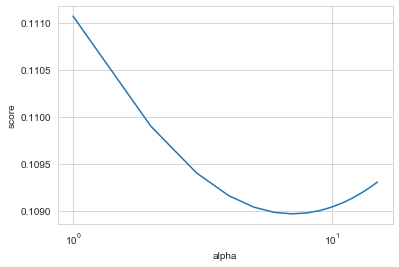


Ridge Score: 0.1090 (alpha = 7.0000)



In [69]:
ridge_alpha = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
ridge_rmse = []

for value in ridge_alpha:
    ridge = make_pipeline(RobustScaler(), Ridge(alpha = value, random_state = 1234))
    ridge_rmse.append(rmse_cv(ridge).mean())
    
ridge_score_table = pd.DataFrame(ridge_rmse,ridge_alpha,columns=['RMSE'])
display(ridge_score_table.transpose())

plt.semilogx(ridge_alpha, ridge_rmse)
plt.xlabel('alpha')
plt.ylabel('score')
plt.show()

print("\nRidge Score: {:.4f} (alpha = {:.4f})\n".format(min(ridge_score_table['RMSE']), ridge_score_table.idxmin()[0]))

In [70]:
ridge = make_pipeline(RobustScaler(), Ridge(alpha = 6, random_state = 1234))
ridge.fit(final_X_train, final_y_train)
ridge_preds = np.expm1(ridge.predict(final_X_test))

sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = ridge_preds
sub.to_csv('Ridge Submission.csv',index=False)

In [71]:
ridge_preds

array([120018.47491044, 153640.37350536, 182651.9469315 , ...,
       168363.05603943, 121204.47292687, 226788.87476267])


### Ridge Regression Score: 0.11938

<br>

## 9.5 XGBoost Model
Since there are multiple hyperparameters to tune in the XGBoost model, we will use the [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function of Sklearn to determine the optimal values. Next, I used the [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to generate a validation set and find the RMSE of the models. This method is used in lieu of the [rmse_cv](#9.2-Defining-a-Cross-Validation-Strategy)
 function used above for the Lasso and Ridge Regression models.

In [ ]:
xg_X_train, xg_X_test, xg_y_train, xg_y_test = train_test_split(final_X_train, final_y_train, test_size=0.33, random_state=1234)

xg_model = XGBRegressor(n_estimators=100, seed = 1234)
param_dict = {'max_depth': [3,4,5],
              'min_child_weight': [2,3,4],
              'learning_rate': [0.05, 0.1,0.15],
              'gamma': [0.0, 0.1, 0.2]
}

start = time()
grid_search = GridSearchCV(xg_model, param_dict)
grid_search.fit(xg_X_train, xg_y_train)
print("GridSearch took %.2f seconds to complete." % (time()-start))
display(grid_search.best_params_)

C:\Users\AnuragMishra\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Now that the hyperparameter have been chosen, we can calculate the validation RMSE of the XGBoost model.

In [65]:
xg_model = XGBRegressor(n_estimators = 1000,
                        learning_rate = 0.1,
                        max_depth = 4,
                        min_child_weight = 4,
                        gamma = 0,
                        seed = 1234)
start = time()
xg_model.fit(xg_X_train, xg_y_train)
xg_preds = xg_model.predict(xg_X_test)
print("Model took %.2f seconds to complete." % (time()-start))
print("RMSE: %.4f" % sqrt(mean_squared_error(xg_y_test, xg_preds)))

Model took 15.84 seconds to complete.
RMSE: 0.1243


Lastly, we predict the <i>SalePrice</i> using the test data. The predictions are then formatted in a appropriate layout for submission to Kaggle.

In [66]:
xg_model = XGBRegressor(n_estimators = 1000,
                        learning_rate = 0.1,
                        max_depth = 4,
                        min_child_weight = 4,
                        gamma = 0,
                        seed = 1234)
xg_model.fit(final_X_train, final_y_train)
xg_preds = np.expm1(xg_model.predict(final_X_test))

In [67]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = xg_preds
sub.to_csv('XGBoost Submission.csv',index=False)


### XGBoost Regression Model: 0.12408

<br>

## 9.6 Ensemble Model
Since the Lasso, Ridge, XGBoost algorithms so different, averaging the final <i>Saleprice</i> predictions may improve the accuracy. Since the Ridge regression performed the best with regards to the final RMSE (0.125 vs 0.126 and 0.127), I will assign it's weight to be double that of the other two models.

Our final ensemble model performed better than any individual regression model (<b>RMSE = 0.12220</b>).

In [68]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.00025, random_state = 1234))
lasso.fit(final_X_train, final_y_train)
lasso_preds = np.expm1(lasso.predict(final_X_test))

ridge = make_pipeline(RobustScaler(), Ridge(alpha = 6, random_state = 1234))
ridge.fit(final_X_train, final_y_train)
ridge_preds = np.expm1(ridge.predict(final_X_test))

xg_model = XGBRegressor(n_estimators = 1000,
                        learning_rate = 0.1,
                        max_depth = 4,
                        min_child_weight = 4,
                        gamma = 0,
                        seed = 1234)
xg_model.fit(final_X_train, final_y_train)
xg_preds = np.expm1(xg_model.predict(final_X_test))

weights = [0.5, 0.25, 0.25]

sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = (ridge_preds*weights[0]) + (lasso_preds*weights[1]) + (xg_preds*weights[2])
sub.to_csv('Ensemble Submission.csv',index=False)


### Ensemble Regression Score: 0.11698

<br>

# 1 Summary

I started this competition by focusing on getting a thorough understanding of the dataset. Particular attention was paid to impute the missing values within the dataset. The EDA process is detailed as well as visualized.

In this project, I created a predictive model that has been trained on data collected from homes in Ames, Iowa. Three algorithms were used, and their validation set RMSE and test set RMSE are listed below:


| Regression Model | Validation RMSE | Test RMSE |
|------------------|-----------------|-----------|
| Ridge            | 0.1130          | 0.12528   |
| Lasso            | 0.1125          | 0.12679   |
| XGBoost          | 0.1238          | 0.12799   |
|                  |
| <b>Ensemble</b>  |                 | 0.12220   |

The Ridge regression model performed the best as a single model, likely due to the high multicollinearity. However, combining it with the Lasso and XGBoost regression models resulting in a higher prediction accuracy and a lower RMSE (<i>0.12220</i> vs <i>0.12528</i>). 